In [0]:
#dependencies
!pip install imageio
!pip install torch
!pip install kaggle
!pip install pywidgets

    100% |████████████████████████████████| 3.3MB 8.7MB/s 
  Running setup.py bdist_wheel for imageio ... - \ | done
  Stored in directory: /root/.cache/pip/wheels/e0/43/31/605de9372ceaf657f152d3d5e82f42cf265d81db8bbe63cde1
Successfully built imageio
    100% |████████████████████████████████| 519.5MB 32kB/s 
tcmalloc: large alloc 1073750016 bytes == 0x58f44000 @  0x7f0fbaa391c4 0x46d6a4 0x5fcbcc 0x4c494d 0x54f3c4 0x553aaf 0x54e4c8 0x54f4f6 0x553aaf 0x54efc1 0x54f24d 0x553aaf 0x54efc1 0x54f24d 0x553aaf 0x54efc1 0x54f24d 0x551ee0 0x54e4c8 0x54f4f6 0x553aaf 0x54efc1 0x54f24d 0x551ee0 0x54efc1 0x54f24d 0x551ee0 0x54e4c8 0x54f4f6 0x553aaf 0x54e4c8
    100% |████████████████████████████████| 61kB 3.9MB/s 
    100% |████████████████████████████████| 235kB 8.9MB/s 
  Running setup.py bdist_wheel for kaggle ... - \ done
  Stored in directory: /root/.cache/pip/wheels/44/2c/df/22a6eeb780c36c28190faef6252b739fdc47145fd87a6642d4
  Running setup.py bdist_wheel for python-slugify ... - d

In [1]:
import os
import numpy as np
import pandas as pd
import imageio
import matplotlib.pyplot as plt
import torch
from torch.utils import data

ModuleNotFoundError: ignored

In [2]:
#upload data from kaggle
from google.colab import files
uploaded = files.upload()

In [0]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle

In [0]:
ls ~/.kaggle

kaggle.json


In [0]:
!chmod 600 ~/.kaggle/kaggle.json

In [0]:
#download kaggle dataset
!kaggle competitions download -c tgs-salt-identification-challenge

  0% 0.00/322k [00:00<?, ?B/s]
100% 322k/322k [00:00<00:00, 62.7MB/s]
  0% 0.00/264k [00:00<?, ?B/s]
100% 264k/264k [00:00<00:00, 70.9MB/s]
  0% 0.00/922k [00:00<?, ?B/s]
100% 922k/922k [00:00<00:00, 137MB/s]
 94% 154M/163M [00:00<00:00, 172MB/s]
100% 163M/163M [00:00<00:00, 214MB/s]
 50% 19.0M/37.9M [00:00<00:00, 103MB/s]
100% 37.9M/37.9M [00:00<00:00, 144MB/s]


In [0]:
#unzip
!unzip train.zip

Archive:  train.zip
   creating: images/
   creating: masks/
  inflating: images/8d08955cdf.png   
  inflating: images/e045664b46.png   
  inflating: images/4989c6509e.png   
  inflating: images/fff4eb4941.png   
  inflating: images/3a310860a3.png   
  inflating: images/7a696bb878.png   
  inflating: images/8d3ee9356b.png   
  inflating: images/213e0a9f7b.png   
  inflating: images/78f17697f2.png   
  inflating: images/bd20d18369.png   
  inflating: images/de08c5a3b7.png   
  inflating: images/f06ef6c8b7.png   
  inflating: images/b2d02516e1.png   
  inflating: images/5edb37f5a8.png   
  inflating: images/b1f0e104f5.png   
  inflating: images/40e8e14e60.png   
  inflating: images/6e1444d88d.png   
  inflating: images/f342603c76.png   
  inflating: images/7ba58ee1be.png   
  inflating: images/14a89a1840.png   
  inflating: images/4319885cf1.png   
  inflating: images/bb697642ae.png   
  inflating: images/d4acb30303.png   
  inflating: images/057eae4f34.png   
  inflating: images/9f0c9f3

In [0]:
#Create a class to represt dataset
class SaltDataset(data.Dataset):
  
  def __init__(self, root_path, file_list):
    self.root_path = root_path
    self.file_list = file_list
    
  def __len__(self):
    return(len(self.file_list))
  
  def __getitem__(self,index):
    file_id = self.file_list[index]
    #image folder + path
    image_folder = os.path.join(self.root_path,'images')
    image_path = os.path.join(image_folder, file_id+'.png')
    #label folder + path
    mask_folder = os.path.join(self.root_path,'masks')
    mask_path = os.path.join(mask_folder, file_id+'.png')
    
    #read it
    image = np.array(imageio.imread(image_path), dtype = np.uint8)
    mask = np.array(imageio.imread(mask_path), dtype = np.uint8)
    
    return image, mask

In [0]:
#read dataset
train_mask = pd.read_csv('train.csv')
depth = pd.read_csv('depths.csv')

train_path = './'

file_list = list(train_mask['id'].values)
dataset = SaltDataset(train_path,file_list)

In [0]:
#visulalize images
def plot2x2array(image, mask):
  f, axarr = plt.subplots(1,2)
  axarr[0].imshow(image)
  axarr[1].imshow(mask)
  axarr[0].grid()
  axarr[1].grid()
  axarr[0].set_title('Image')
  axarr[1].set_title('Mask')

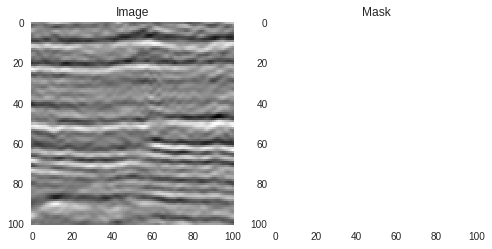

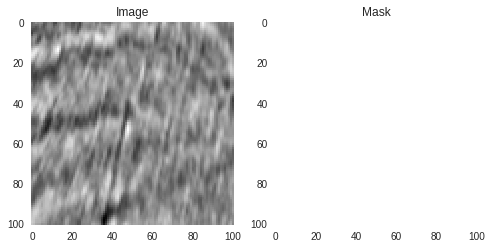

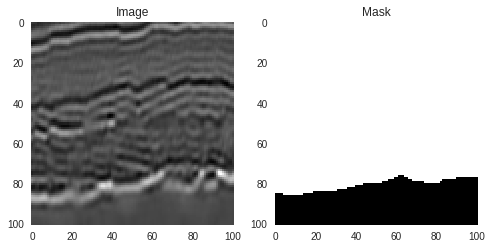

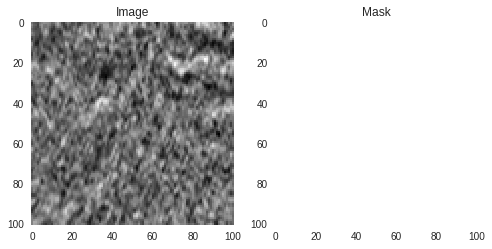

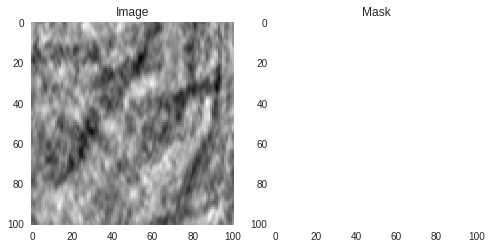

In [0]:
#print images
for i in range(5):
  image, mask = dataset[np.random.randint(0,len(dataset))]
  plot2x2array(image,mask)

Text(0.5,1,'depth distribution')

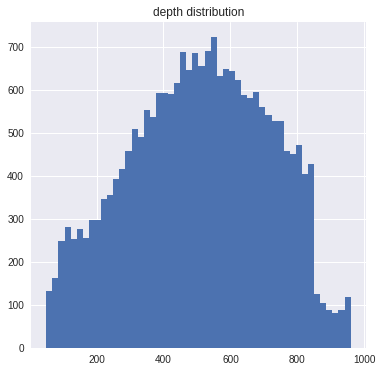

In [0]:
#plot depth distribution
plt.figure(figsize = (6,6))
plt.hist(depth['z'], bins = 50)
plt.title('depth distribution')

In [0]:
#convert rle scheme to input to model
def rleToMask(rleString, height, width):
  rows, cols = height, width
  try:
    rleNumbers = [int(numstring) for numstring in rleString.split(' ')]
    rlePairs = np.array(rleNumbers).reshape(-1,2)
    img = np.zeros(row*colw, dtype = uint8)
    for index, length in rlePairs:
      index = -1
      img[index:index+length] = 255
     
    img = img.reshape(cols, row)
    img = img.T
  except:
    img = np.zeros((cols,rows))
    
  return img

In [0]:
#function for measuring how salty an image is
def salt_proportion(imgArray):
  try:
    unique, counts = np.unique(imgArray, return_counts = True)
    return counts[1]/10201
  except:
    return 0.0

In [0]:
#prep to train depth
train_mask['mask'] = train_mask['rle_mask'].apply(lambda x: rleToMask(x,101,101))
train_mask['salt_proportion'] = train_mask['mask'].apply(lambda x: salt_proportion(x))


In [0]:
#merge it
merged = train_mask.merge(depth, how = 'left')
merged.head()

,id,rle_mask,mask,salt_proportion,z
0,575d24d81d,NaN,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",0.0,843
1,a266a2a9df,5051 5151,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",0.0,794
2,75efad62c1,9 93 109 94 210 94 310 95 411 95 511 96 612 96...,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",0.0,468
3,34e51dba6a,48 54 149 54 251 53 353 52 455 51 557 50 659 4...,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",0.0,727
4,4875705fb0,1111 1 1212 1 1313 1 1414 1 1514 2 1615 2 1716...,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",0.0,797


Text(0.5,1,'Proportion vs Depth')

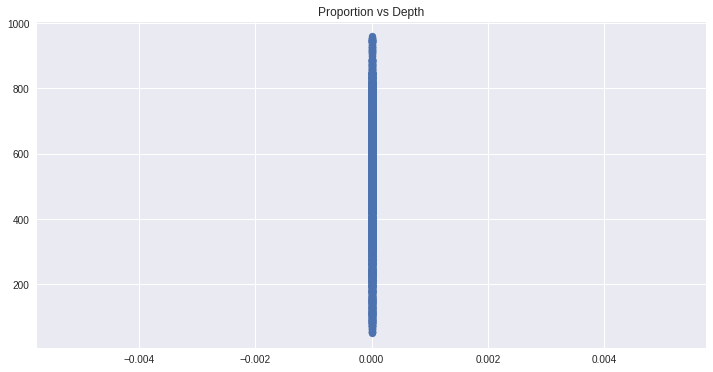

In [0]:
#show salt to depth ratio
plt.figure(figsize=(12,6))
plt.scatter(merged['salt_proportion'], merged['z'])
plt.title('Proportion vs Depth')

In [0]:
from keras.models import Model, load_model
from keras.layers import Input
from keras.layers.core import Lambda, RepeatVector, Reshape
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers.pooling import MaxPooling2D
from keras.layers.merge import concatenate
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from keras import backend as K

In [0]:
im_width = 128
im_height = 128
border = 5
im_chan = 2 # Number of channels: first is original and second cumsum(axis=0)
n_features = 1 # Number of extra features, like depth
#path_train = '../input/train/'
#path_test = '../input/test/'

In [0]:
# Build U-Net model
input_img = Input((im_height, im_width, im_chan), name='img')
input_features = Input((n_features, ), name='feat')

c1 = Conv2D(8, (3, 3), activation='relu', padding='same') (input_img)
c1 = Conv2D(8, (3, 3), activation='relu', padding='same') (c1)
p1 = MaxPooling2D((2, 2)) (c1)

c2 = Conv2D(16, (3, 3), activation='relu', padding='same') (p1)
c2 = Conv2D(16, (3, 3), activation='relu', padding='same') (c2)
p2 = MaxPooling2D((2, 2)) (c2)

c3 = Conv2D(32, (3, 3), activation='relu', padding='same') (p2)
c3 = Conv2D(32, (3, 3), activation='relu', padding='same') (c3)
p3 = MaxPooling2D((2, 2)) (c3)

c4 = Conv2D(64, (3, 3), activation='relu', padding='same') (p3)
c4 = Conv2D(64, (3, 3), activation='relu', padding='same') (c4)
p4 = MaxPooling2D(pool_size=(2, 2)) (c4)

# Join features information in the depthest layer
f_repeat = RepeatVector(8*8)(input_features)
f_conv = Reshape((8, 8, n_features))(f_repeat)
p4_feat = concatenate([p4, f_conv], -1)

c5 = Conv2D(128, (3, 3), activation='relu', padding='same') (p4_feat)
c5 = Conv2D(128, (3, 3), activation='relu', padding='same') (c5)

u6 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same') (c5)
#check out this skip connection thooooo
u6 = concatenate([u6, c4])
c6 = Conv2D(64, (3, 3), activation='relu', padding='same') (u6)
c6 = Conv2D(64, (3, 3), activation='relu', padding='same') (c6)

u7 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same') (c6)
u7 = concatenate([u7, c3])
c7 = Conv2D(32, (3, 3), activation='relu', padding='same') (u7)
c7 = Conv2D(32, (3, 3), activation='relu', padding='same') (c7)

u8 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same') (c7)
u8 = concatenate([u8, c2])
c8 = Conv2D(16, (3, 3), activation='relu', padding='same') (u8)
c8 = Conv2D(16, (3, 3), activation='relu', padding='same') (c8)

u9 = Conv2DTranspose(8, (2, 2), strides=(2, 2), padding='same') (c8)
u9 = concatenate([u9, c1], axis=3)
c9 = Conv2D(8, (3, 3), activation='relu', padding='same') (u9)
c9 = Conv2D(8, (3, 3), activation='relu', padding='same') (c9)

outputs = Conv2D(1, (1, 1), activation='sigmoid') (c9)

model = Model(inputs=[input_img, input_features], outputs=[outputs])
model.compile(optimizer='adam', loss='binary_crossentropy') #, metrics=[mean_iou]) # The mean_iou metrics seens to leak train and test values...
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
img (InputLayer)                (None, 128, 128, 2)  0                                            
__________________________________________________________________________________________________
conv2d_20 (Conv2D)              (None, 128, 128, 8)  152         img[0][0]                        
__________________________________________________________________________________________________
conv2d_21 (Conv2D)              (None, 128, 128, 8)  584         conv2d_20[0][0]                  
__________________________________________________________________________________________________
max_pooling2d_5 (MaxPooling2D)  (None, 64, 64, 8)    0           conv2d_21[0][0]                  
__________________________________________________________________________________________________
conv2d_22 

In [0]:
!pip install ipywidgets

In [0]:
import sys
from tqdm import tqdm
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from skimage.transform import resize
import os


train_ids = next(os.walk(train_path+"images"))[2]


# Get and resize train images and masks
X = np.zeros((len(train_ids), im_height, im_width, im_chan), dtype=np.float32)
y = np.zeros((len(train_ids), im_height, im_width, 1), dtype=np.float32)
X_feat = np.zeros((len(train_ids), n_features), dtype=np.float32)
print('Getting and resizing train images and masks ... ')
sys.stdout.flush()
for n, id_ in tqdm(enumerate(train_ids), total=len(train_ids)):
    path = train_path
    
    # Depth
    #X_feat[n] = depth.loc[id_.replace('.png', ''), 'z']
    
    # Load X
    img = load_img(path + '/images/' + id_, grayscale=True)
    x_img = img_to_array(img)
    x_img = resize(x_img, (128, 128, 1), mode='constant', preserve_range=True)
    
    # Create cumsum x
    x_center_mean = x_img[border:-border, border:-border].mean()
    x_csum = (np.float32(x_img)-x_center_mean).cumsum(axis=0)
    x_csum -= x_csum[border:-border, border:-border].mean()
    x_csum /= max(1e-3, x_csum[border:-border, border:-border].std())

    # Load Y
    mask = img_to_array(load_img(path + '/masks/' + id_, grayscale=True))
    mask = resize(mask, (128, 128, 1), mode='constant', preserve_range=True)

    # Save images
    X[n, ..., 0] = x_img.squeeze() / 255
    X[n, ..., 1] = x_csum.squeeze()
    y[n] = mask / 255

print('Done!')

Getting and resizing train images and masks ... 


100%|██████████| 4000/4000 [00:20<00:00, 199.35it/s]

Done!


In [0]:
from sklearn.model_selection import train_test_split

X_train, X_valid, X_feat_train, X_feat_valid, y_train, y_valid = train_test_split(X, X_feat, y, test_size=0.15, random_state=42)

In [0]:
callbacks = [
    EarlyStopping(patience=5, verbose=1),
    ReduceLROnPlateau(patience=3, verbose=1),
    ModelCheckpoint('model-tgs-salt-1.h5', verbose=1, save_best_only=True, save_weights_only=True)
]

results = model.fit({'img': X_train, 'feat': X_feat_train}, y_train, batch_size=16, epochs=100, callbacks=callbacks,
                    validation_data=({'img': X_valid, 'feat': X_feat_valid}, y_valid))

Train on 3400 samples, validate on 600 samples
Epoch 1/100
3400/3400 [==============================] - 20s 6ms/step - loss: 0.5020 - val_loss: 0.4208

Epoch 00001: val_loss improved from inf to 0.42084, saving model to model-tgs-salt-1.h5
Epoch 2/100
3400/3400 [==============================] - 16s 5ms/step - loss: 0.3693 - val_loss: 0.4367

Epoch 00002: val_loss did not improve from 0.42084
Epoch 3/100
3400/3400 [==============================] - 16s 5ms/step - loss: 0.3164 - val_loss: 0.3504

Epoch 00003: val_loss improved from 0.42084 to 0.35036, saving model to model-tgs-salt-1.h5
Epoch 4/100
3400/3400 [==============================] - 16s 5ms/step - loss: 0.2717 - val_loss: 0.2541

Epoch 00004: val_loss improved from 0.35036 to 0.25408, saving model to model-tgs-salt-1.h5
Epoch 5/100
3400/3400 [==============================] - 16s 5ms/step - loss: 0.2540 - val_loss: 0.2493

Epoch 00005: val_loss improved from 0.25408 to 0.24926, saving model to model-tgs-salt-1.h5
Epoch 6/100
3